In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


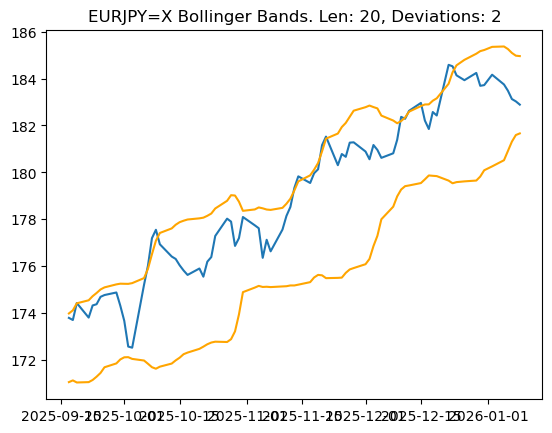

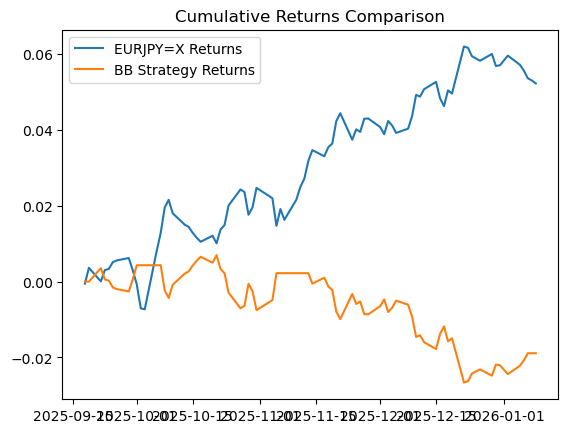

Price,Close,High,Low,Open,Volume,BB_SMA,STD,Upper_Band,Lower_Band,Strategy,signal,Asset_returns,strategy_returns
Date,,,,,,,,,,,,,
2025-09-17,173.800003,173.785995,173.087997,173.800003,0,172.524749,0.731472,173.987692,171.061806,NaN,NaN,NaN,NaN
2025-09-18,173.707993,174.453995,173.589996,173.707993,0,172.627699,0.746470,174.120638,171.134759,0.0,NaN,-0.000529,0.000000
2025-09-19,174.432007,174.477997,173.479004,174.432007,0,172.733549,0.843576,174.420701,171.046397,0.0,-1.0,0.003636,0.000000
2025-09-22,173.811996,174.264999,173.792999,173.811996,0,172.805549,0.872065,174.549678,171.061420,-1.0,NaN,0.000069,0.003554
2025-09-23,174.328995,174.490997,174.052994,174.328995,0,172.938049,0.892957,174.723964,171.152134,-1.0,NaN,0.003044,0.000569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-05,183.746994,184.031998,182.809998,183.744003,0,182.942599,1.212006,185.366610,180.518588,-1.0,NaN,0.057232,-0.022204
2026-01-06,183.479996,183.619995,183.000000,183.457993,0,183.085599,1.085685,185.256968,180.914229,-1.0,NaN,0.055696,-0.020783
2026-01-07,183.126007,183.360992,182.710007,183.080994,0,183.201199,0.945062,185.091323,181.311075,-1.0,0.0,0.053659,-0.018894


In [6]:
ticker = "EURJPY=X"
BB_LENGTH = 20 
devs= 2
LOOKBACK = -100

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_bollinger_bands(df, BB_LENGTH, devs): 
    df['BB_SMA'] = df['Close'].rolling(window=BB_LENGTH).mean() 
    df['STD'] = df['Close'].rolling(window=BB_LENGTH).std()
    df['Upper_Band'] = df['BB_SMA'] + (df['STD'] * devs)
    df['Lower_Band'] = df['BB_SMA'] - (df['STD'] * devs)

    df = df.dropna()

    plt.plot(df['Close'])
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{ticker} Bollinger Bands. Len: {BB_LENGTH}, Deviations: {devs}')

    return df
def strategy(df):
    df['Strategy'] = 0

    conditions = [
        (df['Close'] > df["Upper_Band"]), # Condition 1: Short
        (df['Close'] < df["Lower_Band"]),
        (df['Close'] > df['BB_SMA']) & (df['Close'].shift(1) < df['BB_SMA']), 
        ((df['Close'] < df['BB_SMA']) & (df['Close'].shift(1) > df['BB_SMA']))   
    ]
    choices = [-1, 1, 0, 0]
    df['signal'] = np.select(conditions, choices, default=np.nan)

    df['Strategy'] = df['signal'].ffill()
    df['Strategy'] = df['Strategy'].fillna(0)

    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='BB Strategy Returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_bollinger_bands(df, BB_LENGTH, devs)
    df = strategy(df)
    df = test_strategy(df)
    return df

df = main()
df